In [1]:
import pandas as pd
import numpy as np
np.__version__
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split

import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [5]:
# filterPlateau = filterPlateau[~filterPlateau['DRUG_ID'].isin(toDropDrugs)]
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
param_labels = ['param_'+str(i) for i in range(1,5)]
pred_param_labels = ['pred_param_'+str(i) for i in range(1,5)]
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC'] + resp_labels

fullPredLabels = ['DRUG_COSMICID'] + pred_param_labels
ridgeResults = pd.DataFrame(columns=fullPredLabels)
lassoResults = pd.DataFrame(columns=fullPredLabels)
combinedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ param_labels)
df = None
drugId = 344
drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
notXValuesFilter = resp_labels + notIncludeColumns + conc_labels + param_labels
trainXValues = trainData.drop(columns = notXValuesFilter)
trainYValues = trainData[param_labels]

trainX = trainXValues.reset_index(drop=True).to_numpy()
trainY = trainYValues.reset_index(drop=True).to_numpy()

testXValues = testData.drop(columns = notXValuesFilter)
testYValues = testData[param_labels]

testX = testXValues.reset_index(drop=True).to_numpy()
testY = testYValues.reset_index(drop=True).to_numpy()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ridge_alphas = np.linspace(60, 100, 80)
ridge = Ridge()
grid = dict()
grid['alpha'] = ridge_alphas
gscv = GridSearchCV( \
    ridge, grid, scoring='neg_mean_absolute_error', \
    cv=cv, n_jobs=-1)
results = gscv.fit(trainX, trainY)
print(results.best_params_)

ridge = Ridge(alpha=results.best_params_['alpha'])
ridge.fit(trainX, trainY)
pred_train = ridge.predict(trainX)
pred_test= ridge.predict(testX)
resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsRidge[pred_param_labels] = pred_test
ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 20, 80)
lasso = Lasso()
grid = dict()
grid['alpha'] = lasso_alphas
gscv = GridSearchCV( \
    lasso, grid, scoring='neg_mean_absolute_error', \
    cv=cv, n_jobs=-1)
results = gscv.fit(trainX, trainY)
print(results.best_params_)

lasso = Lasso(alpha=results.best_params_['alpha'])
lasso.fit(trainX, trainY)
pred_trainL = lasso.predict(trainX)
pred_testL= lasso.predict(testX)
resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsLasso[pred_param_labels] = pred_testL
lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)

trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
trueResult[param_labels] = testY
trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)


combinedResult = np.add(pred_test, pred_testL)
divide2 = lambda i: float(i) / 2

vectorized_divide2 = np.vectorize(divide2)

combinedResult = np.asmatrix(vectorized_divide2(combinedResult))
resultsComb = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsComb[pred_param_labels] = combinedResult
combinedResults = combinedResults.append(resultsComb,ignore_index=True,sort=False)
    
    

{'alpha': 76.20253164556962}
{'alpha': 1.518987341772152}


In [6]:
lassoResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-21.592873,0.99876,34.964602,-0.026728
1,344_717431,-16.902531,0.99876,22.884928,-0.026728
2,344_910925,-18.023535,0.99876,26.827342,-0.026728
3,344_908457,-21.130290,0.99876,27.330921,-0.026728
4,344_910853,-13.333194,0.99876,37.779746,-0.026728
5,344_908123,-18.187518,0.99876,36.830271,-0.026728
6,344_905962,-18.023535,0.99876,72.624664,-0.026728
7,344_722045,-20.761780,0.99876,35.201014,-0.026728
8,344_917486,-20.299197,0.99876,19.166567,-0.026728
9,344_906826,-14.618181,0.99876,25.247048,-0.026728


In [7]:
ridgeResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-22.729972,0.994859,41.803143,-0.002984
1,344_717431,-22.773628,0.995222,38.043175,-0.030963
2,344_910925,-17.053417,0.995305,30.363020,-0.009573
3,344_908457,-11.516808,1.004695,19.562152,-0.017925
4,344_910853,-19.064745,0.999218,49.833553,-0.012854
5,344_908123,-15.902039,1.003113,28.419659,-0.031293
6,344_905962,-14.860256,1.000938,30.849785,0.010278
7,344_722045,-18.549344,0.993405,32.098599,-0.028935
8,344_917486,-10.743363,1.001765,23.617752,-0.037065
9,344_906826,-13.187079,1.004175,24.830532,-0.021009


In [8]:
combinedResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-22.161422,0.996810,38.383872,-0.014856
1,344_717431,-19.838080,0.996991,30.464051,-0.028845
2,344_910925,-17.538476,0.997033,28.595181,-0.018151
3,344_908457,-16.323549,1.001728,23.446536,-0.022326
4,344_910853,-16.198969,0.998989,43.806650,-0.019791
5,344_908123,-17.044778,1.000937,32.624965,-0.029010
6,344_905962,-16.441895,0.999849,51.737224,-0.008225
7,344_722045,-19.655562,0.996082,33.649806,-0.027832
8,344_917486,-15.521280,1.000263,21.392159,-0.031896
9,344_906826,-13.902630,1.001468,25.038790,-0.023869


In [9]:
trueResults

,DRUG_COSMICID,param_1,param_2,param_3,param_4
0,344_910851,-16.424564,0.958175,23.736499,0.222941
1,344_717431,-9.979214,1.054327,25.806256,0.003961
2,344_910925,-19.679407,0.997509,25.848962,0.004848
3,344_908457,-2.704682,0.995417,6.327667,-0.086482
4,344_910853,-5.761424,0.934020,7.109135,-0.029411
5,344_908123,-15.216992,0.968251,40.483854,0.004931
6,344_905962,-6.325899,1.009074,10.630912,0.007470
7,344_722045,-8.228032,0.965678,11.533052,0.018718
8,344_917486,-7.537546,0.990734,10.846830,0.001184
9,344_906826,-4.879638,1.043312,8.096253,0.088487


In [10]:
ridgeResults = ridgeResults.drop_duplicates()
lassoResults = lassoResults.drop_duplicates()
combinedResults = combinedResults.drop_duplicates()

In [11]:
def ll4_R(x, c, a, b, d):
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def showTestPredResponses(drugIdCosmic):
    sampleRidge = ridgeResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    ridgeY = sampleRidge[pred_param_labels]
    ridgeY = np.array(ridgeY[pred_param_labels]).squeeze()
    sampleLasso = lassoResults[lassoResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    lassoY = sampleLasso[pred_param_labels]
    lassoY = np.array(lassoY[pred_param_labels]).squeeze()
    sampleComb = combinedResults[combinedResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    combY = sampleComb[pred_param_labels]
    combY = np.array(combY[pred_param_labels]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[param_labels]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 100)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *ridgeY), color="g", label = "Ridge")
    plt.plot(xValues, ll4_R(xValues, *lassoY), color="r", label = "Lasso")
    plt.plot(xValues, ll4_R(xValues, *combY), color="y", label = "Combined")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

[-16.42456381   0.95817463  23.73649913   0.22294058]


<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


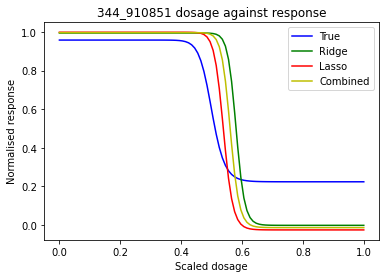

In [12]:
showTestPredResponses('344_910851')

[-9.97921396e+00  1.05432725e+00  2.58062563e+01  3.96075799e-03]


<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


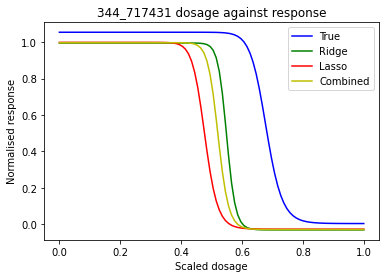

In [13]:
showTestPredResponses('344_717431')

[-2.70468186  0.9954165   6.32766721 -0.0864821 ]


<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


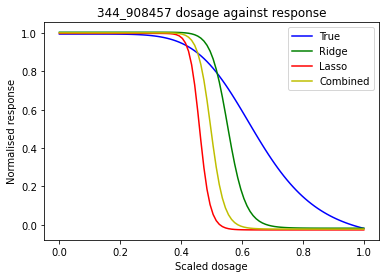

In [14]:
showTestPredResponses('344_908457')

[-1.17265489e+01  9.80967674e-01  1.51631772e+01  4.60009456e-03]


<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-11-0d806dbf1282>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


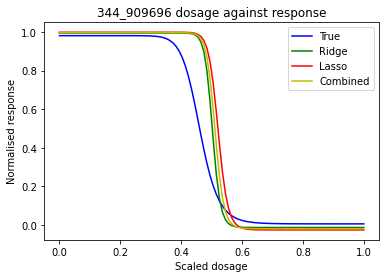

In [15]:
showTestPredResponses('344_909696')